In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
pd.__version__

'1.3.5'

In [3]:
CARIACO = xr.open_dataset("../annotatedDATA/CARIACO_merged_02.nc")

In [4]:
CARIACO

<xarray.Dataset>
Dimensions:                       (time: 256)
Coordinates:
  * time                          (time) datetime64[ns] 1995-11-01 ... 2017-0...
Data variables:
    time_month                    (time) object ...
    cdww                          (time) float64 ...
    iews                          (time) float64 ...
    inss                          (time) float64 ...
    mcc                           (time) float64 ...
    mwp                           (time) float64 ...
    si10                          (time) float64 ...
    sp                            (time) float64 ...
    sst                           (time) float64 ...
    t2m                           (time) float64 ...
    tauoc                         (time) float64 ...
    u10                           (time) float64 ...
    ust                           (time) float64 ...
    v10                           (time) float64 ...
    v10n                          (time) float64 ...
    vst                           (time) float64 ...
    wind                          (time) float64 ...
    cdir                          (time) int32 ...
    e                             (time) float64 ...
    ewss                          (time) float64 ...
    i10fg                         (time) float64 ...
    lsp                           (time) float64 ...
    magss                         (time) float64 ...
    mer                           (time) float64 ...
    metss                         (time) float64 ...
    mmtss                         (time) float64 ...
    mntss                         (time) float64 ...
    mtpr                          (time) float64 ...
    nsss                          (time) float64 ...
    sshf                          (time) int32 ...
    tp                            (time) float64 ...
    O2_ml_L                       (time) float64 ...
    O2_umol_kg                    (time) float64 ...
    NO3_UDO                       (time) float64 ...
    PO4_UDO                       (time) float64 ...
    SiO4_UDO                      (time) float64 ...
    NH4_USF                       (time) float64 ...
    NO2_USF                       (time) float64 ...
    NO3_NO2_USF                   (time) float64 ...
    PO4_USF                       (time) float64 ...
    SiO4_USF                      (time) float64 ...
    pH                            (time) float64 ...
    Alkalinity_mol_kg             (time) float64 ...
    Alkalinity_umol_kg            (time) float64 ...
    TCO2                          (time) float64 ...
    fCO2                          (time) float64 ...
    pH_corrected                  (time) float64 ...
    TCO2_corrected                (time) float64 ...
    fCO2_corrected                (time) float64 ...
    Salinity_bottles              (time) float64 ...
    Salinity_CTD                  (time) float64 ...
    Temperature                   (time) float64 ...
    Sigma_t                       (time) float64 ...
    TPP                           (time) float64 ...
    PIP                           (time) float64 ...
    POC_ug_kg                     (time) float64 ...
    PON_ug_kg                     (time) float64 ...
    POC_ug_L                      (time) float64 ...
    PN_ug_L                       (time) float64 ...
    C_N_particulate               (time) float64 ...
    DON                           (time) float64 ...
    DOP                           (time) float64 ...
    DOC                           (time) float64 ...
    TOC                           (time) float64 ...
    PrimaryProductivity           (time) float64 ...
    Chlorophyll                   (time) float64 ...
    Phaeopigments                 (time) float64 ...
    Total_Prokaryotes             (time) float64 ...
    Bact_Biomass_mgC_m3           (time) float64 ...
    Bact_Biomass_uMC              (time) float64 ...
    NO3_USF                       (time) float64 ...
    NO3_merged                    (time) float64 ...
    PO4_merged  

# Collect Plot functions for Data Catalogue

what do i want to do? -> show general trends and yearly dynamics

plots to do it:
- colormap year month
- time series with linear trend
- deviation from mean

## 2 ways to present:
- do one type of plot for all data
- all 3 plots per data type

2nd option is better!

## colormap

In [5]:
#chl_pd.values
#from matplotlib.pyplot import figure
def plot_yearmonth_cmap(ax, data, bottom0=False, negativemax=False):
    
    data_pd = data.to_dataframe()
    
    dat_pivot = (data_pd.assign(year=data_pd.index.year, month=data_pd.index.month)
      .pivot_table(index='year', columns='month', values=data.name, dropna=False)
    )

    if negativemax == True:
        c = ax.pcolormesh(dat_pivot, cmap='cividis_r')
    else:
        c = ax.pcolormesh(dat_pivot, cmap='cividis')
        
    cbar = plt.colorbar(c, ax=ax, aspect=50)
    
    cbar.set_label(data.attrs['long_name'] + ' ' + data.attrs['units'])
    if bottom0 == True:
        c.set_clim(0)
    else:
        pass
    
    ax.set_yticks(np.arange(0,len(dat_pivot.index.values)))
    ax.set_yticklabels(dat_pivot.index.values)
    ax.set_ylabel('Years')
    
    ax.set_xticks(np.arange(0,12)+1-0.5)
    ax.set_xticklabels(np.arange(1,13))
    ax.set_xlabel('Months')

    return ax

## trends over time series

- plot regimes somehow? rolling yearly mean?

In [6]:
import matplotlib.dates as mdates

def plot_timeseries_withtrend(ax, data, bottom0=False):

    ax.xaxis.set_minor_locator(mdates.YearLocator())
    
    ax.grid(True,which='both', color='lightgrey')
    ax.tick_params(top=False, right=True, direction="in")
    
    #plot time series
    ax.plot(data.time, data, c='black', lw=0.5, zorder=0)
    ax.scatter(data.time, data, c='black', marker='x', zorder=0)
    
    if bottom0 == True:
        ax.set_ylim(bottom=0)
        
    # plot linear reg
    idx = np.isfinite(data.values)
    fit = np.polyfit(mdates.date2num(data.time[idx]), data.values[idx].flatten(), 1)
    fit_fn = np.poly1d(fit)
    
    ax.plot(data.time, fit_fn(mdates.date2num(data.time)), label='linear reg', zorder=5)
    
    return ax

## deviation from mean

In [7]:
yearly_mean = CARIACO.DON.groupby(CARIACO.DON.time.dt.year).mean()
yearly_mean

years = np.unique(CARIACO.DON.time.astype('datetime64[Y]'))
years

array(['1995-01-01T00:00:00.000000000', '1996-01-01T00:00:00.000000000',
       '1997-01-01T00:00:00.000000000', '1998-01-01T00:00:00.000000000',
       '1999-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
       '2001-01-01T00:00:00.000000000', '2002-01-01T00:00:00.000000000',
       '2003-01-01T00:00:00.000000000', '2004-01-01T00:00:00.000000000',
       '2005-01-01T00:00:00.000000000', '2006-01-01T00:00:00.000000000',
       '2007-01-01T00:00:00.000000000', '2008-01-01T00:00:00.000000000',
       '2009-01-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000',
       '2011-01-01T00:00:00.000000000', '2012-01-01T00:00:00.000000000',
       '2013-01-01T00:00:00.000000000', '2014-01-01T00:00:00.000000000',
       '2015-01-01T00:00:00.000000000', '2016-01-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [8]:
def plot_deviationfrommean(ax, data, bottom0=False):

    ax.xaxis.set_minor_locator(mdates.YearLocator())
    
    ax.grid(True,which='both', color='lightgrey')
    ax.tick_params(top=False, right=True, direction="in")
    
    #ax.plot(data.time, data, c='black', lw=0.5, zorder=0)
    
    yearly_mean = data.groupby(data.time.dt.year).mean()
    
    yearly_counts = data.groupby(data.time.dt.year).count()
    
    yearly_mean[yearly_counts<5] = np.nan
    
    years = np.unique(data.time.astype('datetime64[Y]'))

    dat_mean = np.nanmean(data.values)
    #plot time series
    #ax.bar(x=data.time, height=data-dat_mean, align='edge', bottom=dat_mean, width=7.5)#, width=1)
    
    ax.bar(x=years, height=yearly_mean-dat_mean, align='edge', bottom=dat_mean, width=365.1, alpha=0.5)#, width=1)

    ax.axhline(y=dat_mean)

    if bottom0 == True:
        ax.set_ylim(bottom=0)
    ax.set_xlim(years[0], years[len(years)-1])
    
    return ax

# create large multiplots to export to PDF pages

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

def create_3data_panelpage(datasets, page=0, subset='FILL', bottom0=False):
    #mpl.use('pdf')

    description = 'Page: %s, Subset: %s'%(page, subset)

    title_fontsize = 'large'
    fig = plt.figure(dpi=400, tight_layout=True)
    fig.set_size_inches(8.27*1.5, 11.69*1.5, forward=True)

    #plt.figtext(0.02, .999, description, fontsize = 'small')

    ax = np.zeros(9, dtype=object)
    gs = fig.add_gridspec(6, 3, height_ratios=[1,1,1,1,1,1],)
    ax[0] = fig.add_subplot(gs[:2, 0])
    ax[1] = fig.add_subplot(gs[0, 1:])
    ax[2] = fig.add_subplot(gs[1, 1:])

    ax[3] = fig.add_subplot(gs[2:4, 0])
    ax[4] = fig.add_subplot(gs[2, 1:])
    ax[5] = fig.add_subplot(gs[3, 1:])

    ax[6] = fig.add_subplot(gs[4:6, 0])
    ax[7] = fig.add_subplot(gs[4, 1:])
    ax[8] = fig.add_subplot(gs[5, 1:])

    plot_yearmonth_cmap(ax[0], datasets[0], bottom0=bottom0)
    ax[0].set_title(datasets[0].name, fontsize = title_fontsize)
    plot_timeseries_withtrend(ax[1], datasets[0], bottom0=bottom0)
    attrs0 = datasets[0].attrs
    ax[1].set_title('Long name: %s, Source: %s, Subset: %s'%(attrs0['long_name'], attrs0['source'], attrs0['subset']))
    plot_deviationfrommean(ax[2], datasets[0], bottom0=bottom0)

    plot_yearmonth_cmap(ax[3], datasets[1], bottom0=bottom0)
    ax[3].set_title(datasets[1].name, fontsize = title_fontsize)
    plot_timeseries_withtrend(ax[4], datasets[1], bottom0=bottom0)
    attrs1 = datasets[1].attrs
    ax[4].set_title('Long name: %s, Source: %s, Subset: %s'%(attrs1['long_name'], attrs1['source'], attrs1['subset']))
    plot_deviationfrommean(ax[5], datasets[1], bottom0=bottom0)

    plot_yearmonth_cmap(ax[6], datasets[2], bottom0=bottom0)
    ax[6].set_title(datasets[2].name, fontsize = title_fontsize)
    plot_timeseries_withtrend(ax[7], datasets[2], bottom0=bottom0)
    attrs1 = datasets[2].attrs
    ax[7].set_title('Long name: %s, Source: %s, Subset: %s'%(attrs1['long_name'], attrs1['source'], attrs1['subset']))
    plot_deviationfrommean(ax[8], datasets[2], bottom0=bottom0)

    return ax

# CREATE MULTIPAGE PDF

passing  time_month
adding cdww
adding iews
adding inss
adding mcc
adding mwp
adding si10
adding sp
adding sst
adding t2m
adding tauoc
adding u10
adding ust
adding v10
adding v10n
adding vst
adding wind
adding cdir
adding e
adding ewss
adding i10fg
adding lsp
adding magss
adding mer
adding metss
adding mmtss
adding mntss
adding mtpr
adding nsss
adding sshf
adding tp
adding O2_ml_L
adding O2_umol_kg
adding NO3_UDO
adding PO4_UDO
adding SiO4_UDO
adding NH4_USF
adding NO2_USF
adding NO3_NO2_USF
adding PO4_USF
adding SiO4_USF
adding pH
adding Alkalinity_mol_kg
adding Alkalinity_umol_kg
adding TCO2
adding fCO2
adding pH_corrected
adding TCO2_corrected
adding fCO2_corrected
adding Salinity_bottles
adding Salinity_CTD
adding Temperature
adding Sigma_t
adding TPP
adding PIP
adding POC_ug_kg
adding PON_ug_kg
adding POC_ug_L
adding PN_ug_L
adding C_N_particulate
adding DON
adding DOP
adding DOC
adding TOC
adding PrimaryProductivity
adding Chlorophyll
adding Phaeopigments
adding Total_Prokaryotes

AttributeError: 'NoneType' object has no attribute 'finalize'

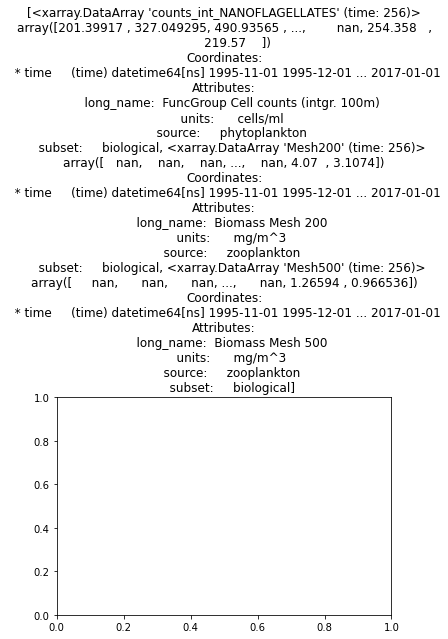

In [10]:
import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Create the PdfPages object to which we will save the pages:
# The with statement makes sure that the PdfPages object is closed properly at
# the end of the block, even if an Exception occurs.
with PdfPages('CARIACO_full_data.pdf') as pdf:

    
    data2plotlist = []
    for val in list(CARIACO.data_vars):
        if val in ['time_month',]:
            print('passing ', val)
        else:
            print('adding', val)
            data2plotlist.append(val)
    
    for slicelist in zip(*(iter(data2plotlist),) * 3):
        datlist = []
        for val in slicelist:
                datlist.append(CARIACO[val])
        plt.title(datlist)
        print("creating plots", datlist)
        create_3data_panelpage(datlist)
        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()

    # We can also set the file's metadata via the PdfPages object:
    d = pdf.infodict()
    d['Title'] = 'CARIACO data catalogue'
    d['Author'] = 'Benjamin Post'
    d['Subject'] = 'Overview and preliminary analysis of CARIACO time series data from in-situ, ERA5 climate model and SeaWiFs satellite data'
    d['Keywords'] = 'Cariaco Venezuela Ocean Time Series Phytoplankton ERA5'
    d['CreationDate'] = datetime.datetime(2021, 12, 17)
    d['ModDate'] = datetime.datetime.today()
    
    pdf.close()
    print("PDF DONE!")